# Introduction
* In this notebook, I will explor PyStan package.[Reference](https://pystan.readthedocs.io/en/latest/getting_started.html)
* There are two main sections here:
    * Explore the mechanism behind PyStan.
    * Explore the "Eight School" example to understand the bayesian analysis more.

In [1]:
import pystan
import scipy
import arviz
import chart_studio.plotly  as py
import plotly.express as px
import plotly.graph_objs as go
import psutil

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# II. Explore the mechanism behind **PyStan**
Create two samples (gamma distribution) and use PyStan to see fitting results

### The sample data (visiting time of two groups)

In [55]:
# Create two samples (gamma distribution) and use PyStan to see fitting results
# Assume this is an AB test experiment (Landing-page visiting time)

size = 270
shape_list = [0.85, 1]  # k  (alpha)
scale_general = 10  # theta   (beta = 1 / theta)

control = np.random.gamma(shape=shape_list[0], scale=scale_general, size=size)
experimental = np.random.gamma(shape=shape_list[1], scale=scale_general, size=size)

In [56]:
# control group data - first 20
print('The first 20 data of control group: ')
print(control[:20])
print('\n')
print('The first 20 data of experimental group: ')
print(experimental[:20])

The first 20 data of control group: 
[11.92402385  4.7121791   2.72246858 18.85053211 22.46080496  2.7919691
 21.93377077  3.17357211  4.07708615  0.2089681  13.54514458 20.06593471
  2.19486396  6.94496607  5.17590487 10.87666939  1.79239166  8.66865582
  7.37516199  4.90295296]


The first 20 data of experimental group: 
[6.42930176e+00 1.09748412e+01 6.86947202e+00 1.22369152e+01
 5.76565637e+00 1.06699219e+01 4.22246346e+00 5.16555807e+00
 1.30268133e+00 9.80166303e+00 3.35261358e+01 1.07151400e+01
 7.63393706e+00 1.98315465e+01 2.27812783e+01 1.96834764e-02
 1.75257456e+01 1.99222462e+01 6.84746596e+00 3.31695126e-01]


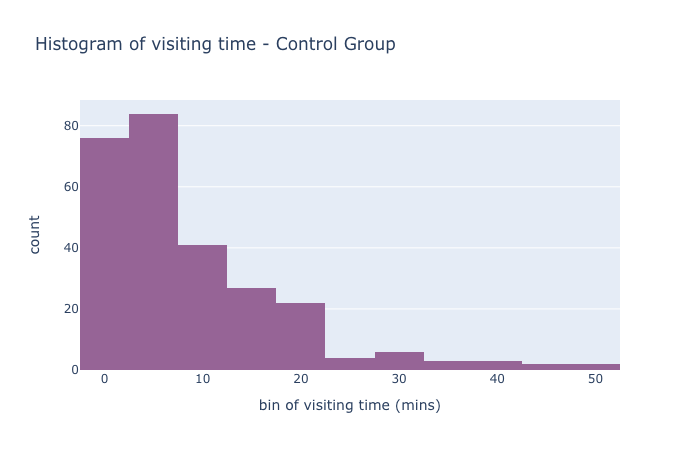

In [57]:
# Control Group
fig = px.histogram(x=control, labels={"x":"bin of visiting time (mins)"}, 
                   title='Histogram of visiting time - Control Group',
                  nbins=25, color_discrete_sequence=['rgb(150,100,150)'])
fig.show("png")

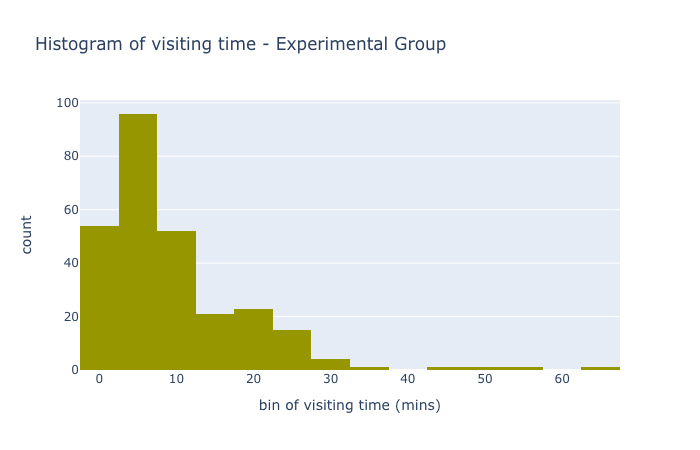

In [58]:
# Experimental Group
fig = px.histogram(x=experimental, labels={"x":"bin of visiting time (mins)"}, 
                   title='Histogram of visiting time - Experimental Group',
                   nbins=25, color_discrete_sequence=['rgb(150,150,0)'])
fig.show("png")

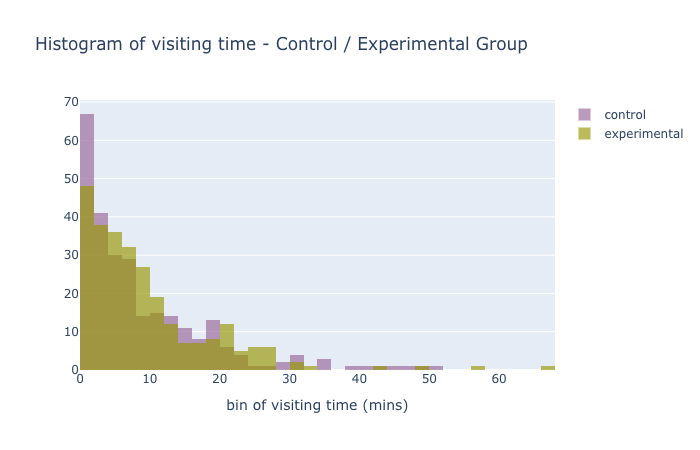

In [59]:
# Plots of two groups
fig = go.Figure()
fig.add_trace(go.Histogram(x=control, 
                           #nbinsx=25, 
                           bingroup=1, # to share the same bins
                           xbins=dict( # bins used for histogram
                                start=0,
                                #end=3.0,
                                #size=0.5
                            ),
                           name='control', 
                           marker=dict(
                                color="rgb(150,100,150)")
                            ))
fig.add_trace(go.Histogram(x=experimental, 
                           #nbinsx=25, 
                           bingroup=1, # to share the same bins
                           xbins=dict( # bins used for histogram
                                start=0,
                                #end=3.0,
                                #size=0.5
                            ),
                           name='experimental', 
                           marker=dict(
                                color="rgb(150,150,0)")
                            ))

# Overlay both histograms
fig.update_layout(barmode='overlay', title='Histogram of visiting time - Control / Experimental Group',
                 xaxis_title="bin of visiting time (mins)")

# Reduce opacity to see both histograms
fig.update_traces(opacity=0.65)
fig.show("png")

### PyStan
Use PyStan to create and fit model (Two gamma models)

In [60]:
# Create and fit PyStan Model

control_experimental_code = """
data {
    int<lower=0> J; // length of data
    vector[J] x1; // control
    vector[J] x2; // experimental
}
parameters {
    real<lower=0> alpha1;  // shape1
    real<lower=0> alpha2;  // shape2
    real<lower=0> theta;   // 1/scale
}
model {
    x1 ~ gamma(alpha1, 1/theta);
    x2 ~ gamma(alpha2, 1/theta);
}

generated quantities {
    real d;
    
    d = alpha2 - alpha1;
}
"""

control_experimental_data = {
                'J': size,
               'x1': control,
               'x2': experimental}

sm = pystan.StanModel(model_code=control_experimental_code)
fit = sm.sampling(data=control_experimental_data, iter=3000, warmup=300, chains=3)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_a48382a6a3a3d78f29315ba6560c2c8a NOW.


In [61]:
# Get the fitting results
print(fit)

Inference for Stan model: anon_model_a48382a6a3a3d78f29315ba6560c2c8a.
3 chains, each with iter=3000; warmup=300; thin=1; 
post-warmup draws per chain=2700, total post-warmup draws=8100.

         mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
alpha1   0.87  9.2e-4   0.06   0.76   0.83   0.87   0.91   0.98   3678    1.0
alpha2   0.99  1.0e-3   0.06   0.87   0.94   0.99   1.03   1.11   3580    1.0
theta    9.95    0.01   0.69   8.72   9.47   9.91  10.39  11.43   3276    1.0
d        0.12  8.2e-4   0.06-8.7e-3   0.07   0.12   0.16   0.25   6131    1.0
lp__    -1733    0.02   1.26  -1736  -1734  -1733  -1732  -1732   3052    1.0

Samples were drawn using NUTS at Fri Mar  6 15:51:22 2020.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


In [62]:
# Each posterior distribution
Alpha1 = fit.extract(permuted=True)['alpha1']
Alpha2 = fit.extract(permuted=True)['alpha2']
Theta = fit.extract(permuted=True)['theta']
D = fit.extract(permuted=True)['d']
Lp__ = fit.extract(permuted=True)['lp__']
summary = fit.summary()

In [63]:
summary

OrderedDict([('summary',
              array([[ 8.70307574e-01,  9.18303894e-04,  5.56894776e-02,
                       7.62573956e-01,  8.32898521e-01,  8.70198191e-01,
                       9.07378098e-01,  9.80487759e-01,  3.67767575e+03,
                       1.00076608e+00],
                     [ 9.87914187e-01,  1.03672874e-03,  6.20341616e-02,
                       8.70532794e-01,  9.44700867e-01,  9.86485716e-01,
                       1.02949602e+00,  1.11004325e+00,  3.58040004e+03,
                       1.00169270e+00],
                     [ 9.95035373e+00,  1.21235012e-02,  6.93885265e-01,
                       8.71584716e+00,  9.46748972e+00,  9.91328955e+00,
                       1.03907718e+01,  1.14311422e+01,  3.27581384e+03,
                       1.00072617e+00],
                     [ 1.17606613e-01,  8.19949828e-04,  6.42036628e-02,
                      -8.70271705e-03,  7.43166173e-02,  1.17448582e-01,
                       1.61587869e-01,  2.45478758e-

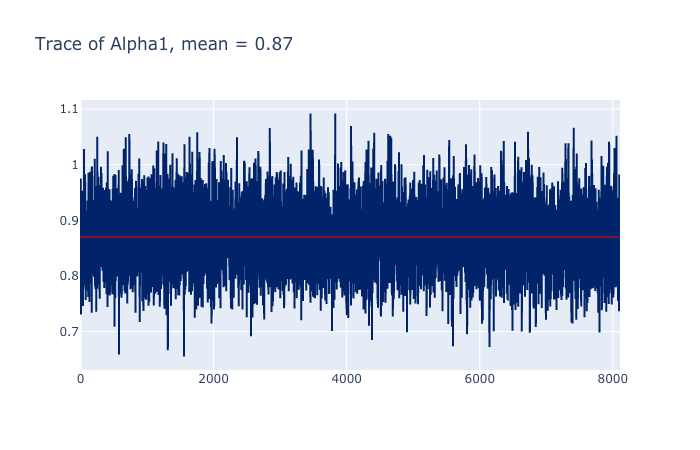

In [64]:
# Plot of Alpha1 (trace)
fig = go.Figure(
    data=[go.Scatter(y=Alpha1, marker=dict(color='rgb(0,35,105)'))],
    layout_title_text=("Trace of Alpha1, mean = {:.2f}".format(Alpha1.mean()))
    
)

hline = go.layout.Shape(type="line", x0=0, y0=Alpha1.mean(), 
                        x1=8100, y1=Alpha1.mean(),
                        line=dict(color="red", width=1, dash="solid")
                       )
                       
fig.add_shape(hline)
fig.show("png")

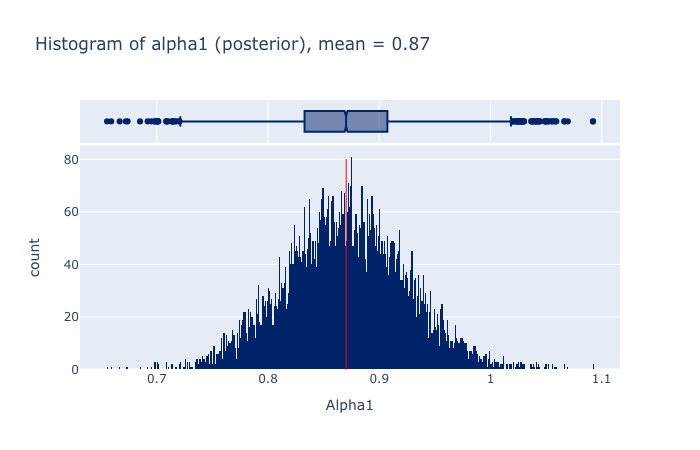

In [65]:
# Plot of Alpha1 (Distribution)
fig = px.histogram(x=Alpha1, labels={"x":"Alpha1"}, marginal='box', nbins=500,
                   title='Histogram of alpha1 (posterior), mean = {:.2f}'.format(Alpha1.mean()),
                   color_discrete_sequence=['rgb(0,35,105)']
                   # range_x=(0.75,0.85)
                  )

vline = go.layout.Shape(type="line", x0=Alpha1.mean(), y0=0, x1=Alpha1.mean(), y1=80, 
                        line=dict(color="red", width=1, dash="solid"))
fig.add_shape(vline)
fig.show("png")

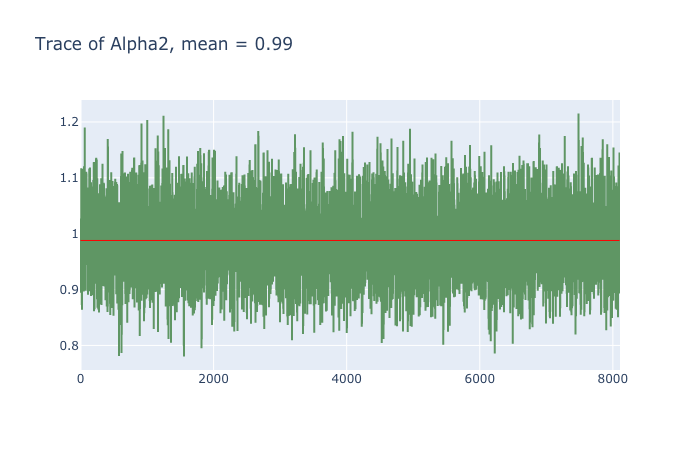

In [66]:
# Plot of Alpha2 (trace)
fig = go.Figure(
    data=[go.Scatter(y=Alpha2, marker=dict(color='rgb(95,150,100)'))],
    layout_title_text=("Trace of Alpha2, mean = {:.2f}".format(Alpha2.mean()))
    
)

hline = go.layout.Shape(type="line", x0=0, y0=Alpha2.mean(), 
                        x1=8100, y1=Alpha2.mean(),
                        line=dict(color="red", width=1, dash="solid")
                       )
                       
fig.add_shape(hline)
fig.show("png")

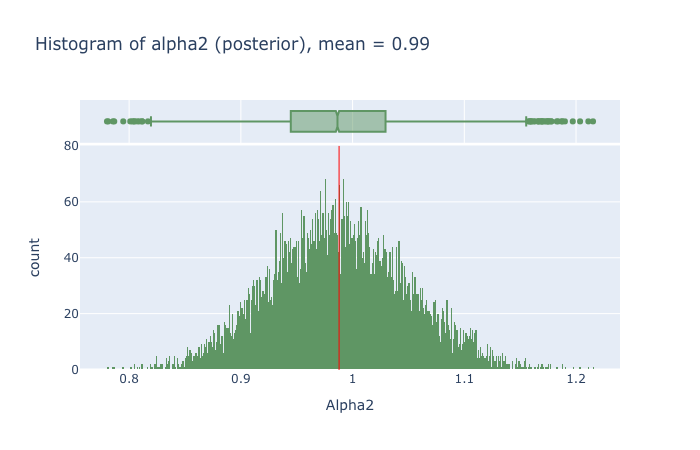

In [67]:
# Plot of Alpha2 (Distribution)
fig = px.histogram(x=Alpha2, labels={"x":"Alpha2"}, marginal='box', nbins=500,
                   title='Histogram of alpha2 (posterior), mean = {:.2f}'.format(Alpha2.mean()),
                   color_discrete_sequence=['rgb(95,150,100)']
                   # range_x=(0.75,0.85)
                  )

vline = go.layout.Shape(type="line", x0=Alpha2.mean(), y0=0, x1=Alpha2.mean(), y1=80, 
                        line=dict(color="red", width=1, dash="solid"))
fig.add_shape(vline)
fig.show("png")

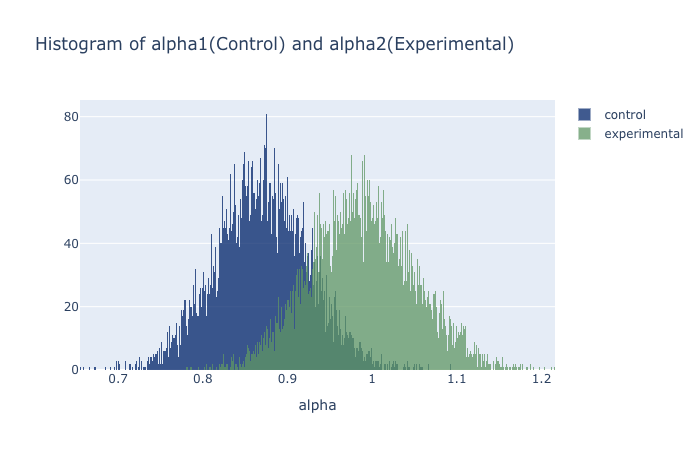

In [68]:
# Alpha1 & Alpha2
fig = go.Figure()
fig.add_trace(go.Histogram(x=Alpha1, nbinsx=500, name='control', 
                           marker=dict(
                                color="rgb(0,35,105)")
                            ))
fig.add_trace(go.Histogram(x=Alpha2, nbinsx=500, name='experimental', 
                           marker=dict(
                                color="rgb(95,150,100)")
                            ))

# Overlay both histograms
fig.update_layout(barmode='overlay', title='Histogram of alpha1(Control) and alpha2(Experimental)',
                 xaxis_title="alpha")
# Reduce opacity to see both histograms
fig.update_traces(opacity=0.75)
fig.show("png")

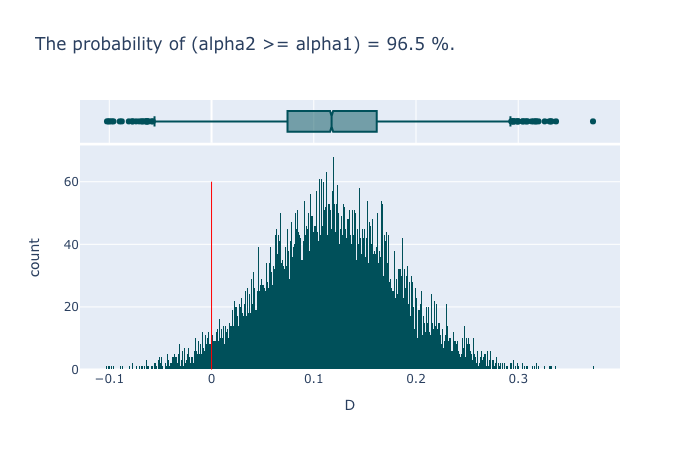

In [69]:
title = 'The probability of (alpha2 >= alpha1) = {:.1f} %.'.format(100 * np.sum(D>0)/len(D))
fig = px.histogram(x=D, labels={"x":"D"}, marginal='box', title=title, color_discrete_sequence=['rgb(0, 80, 90)'], nbins=500)
vline = go.layout.Shape(type="line", x0=0, y0=0, x1=0, y1=60, line=dict(color="red", width=1, dash="solid"))
fig.add_shape(vline)
fig.show("png")

#### Summary
* The probability of (alpha2 >= alpha1) is 85.9%, it is difficult to say the control group have positive effect.

# II. Explore the **Eight School** example 
Use the small data to explore bayesian analysis deeply